In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import TruncatedSVD
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

In [3]:
# Chargement des données
df = pd.read_csv('data.csv')

In [7]:
# show the data
print(df.head())

   id                                        description  \
0   1  Active classic boxers - There's a reason why o...   
1   2  Active sport boxer briefs - Skinning up Glory ...   
2   3  Active sport briefs - These superbreathable no...   
3   4  Alpine guide pants - Skin in, climb ice, switc...   
4   5  Alpine wind jkt - On high ridges, steep ice an...   

                                   clean_description  \
0  active classic boxers - there's a reason why o...   
1  active sport boxer briefs - skinning up glory ...   
2  active sport briefs - these superbreathable no...   
3  alpine guide pants - skin in, climb ice, switc...   
4  alpine wind jkt - on high ridges, steep ice an...   

                              lemmatized_description  
0  active classic boxer - there be a reason why o...  
1  active sport boxer brief - skin up glory requi...  
2  active sport brief - these superbreathable no ...  
3  alpine guide pant - skin in , climb ice , swit...  
4  alpine wind jkt - on hig

In [8]:
# 1. Prétraitement des données textuelles
def preprocess_text(text):
    # Suppression des balises HTML
    text = re.sub('<[^<]+?>', '', text)
    # Conversion en minuscules
    text = text.lower()
    return text

In [9]:
# Application du prétraitement
df['clean_description'] = df['description'].apply(preprocess_text)

In [10]:
# Chargement du modèle spaCy pour la lemmatisation
nlp = spacy.load('en_core_web_sm')

def lemmatize_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

# Lemmatisation des descriptions
df['lemmatized_description'] = df['clean_description'].apply(lemmatize_text)

In [11]:
# Création de la matrice TF-IDF
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['lemmatized_description'])

# display the matrix
print(tfidf_matrix)

In [12]:
# 2. Clustering avec DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=5, metric='cosine')
clusters = dbscan.fit_predict(tfidf_matrix)

# Ajout des clusters au DataFrame
df['cluster'] = clusters

In [13]:
# Fonction pour afficher les wordclouds par cluster
def display_cluster_wordclouds(df, tfidf_matrix, clusters):
    unique_clusters = set(clusters)
    for cluster in unique_clusters:
        if cluster != -1:  # Ignorer les outliers
            cluster_mask = clusters == cluster
            cluster_text = ' '.join(df[cluster_mask]['lemmatized_description'])
            
            wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_text)
            plt.figure(figsize=(10, 5))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis('off')
            plt.title(f'Word Cloud - Cluster {cluster}')
            plt.show()

In [14]:
# 3. Système de recommandation
def find_similar_items(item_id, df, n_recommendations=5):
    if item_id not in df['id'].values:
        return "Item ID not found"
    
    item_cluster = df[df['id'] == item_id]['cluster'].iloc[0]
    if item_cluster == -1:
        return "Item is an outlier, no similar items found"
    
    # Trouver les items du même cluster
    similar_items = df[df['cluster'] == item_cluster]
    similar_items = similar_items[similar_items['id'] != item_id]
    
    return similar_items['id'].head(n_recommendations).tolist()

In [15]:
# 4. Topic Modeling avec TruncatedSVD
n_topics = 15
svd = TruncatedSVD(n_components=n_topics)
topic_encoded = svd.fit_transform(tfidf_matrix)

# Création du DataFrame des topics
topic_encoded_df = pd.DataFrame(topic_encoded, columns=[f'Topic_{i+1}' for i in range(n_topics)])
df['main_topic'] = topic_encoded_df.idxmax(axis=1)

In [16]:
# Fonction pour afficher les wordclouds par topic
def display_topic_wordclouds(tfidf_matrix, svd, feature_names, n_topics):
    for topic_idx in range(n_topics):
        # Obtenir les mots les plus importants pour ce topic
        top_words_idx = svd.components_[topic_idx].argsort()[:-10:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        
        # Créer le wordcloud
        text = ' '.join(top_words)
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
        
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud - Topic {topic_idx + 1}')
        plt.show()

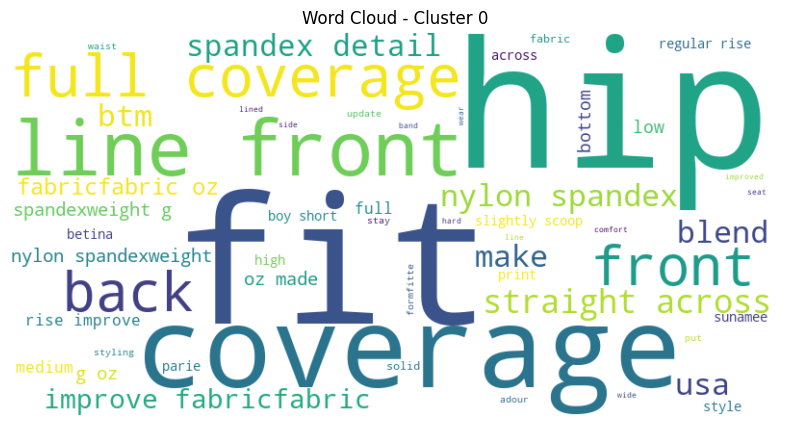

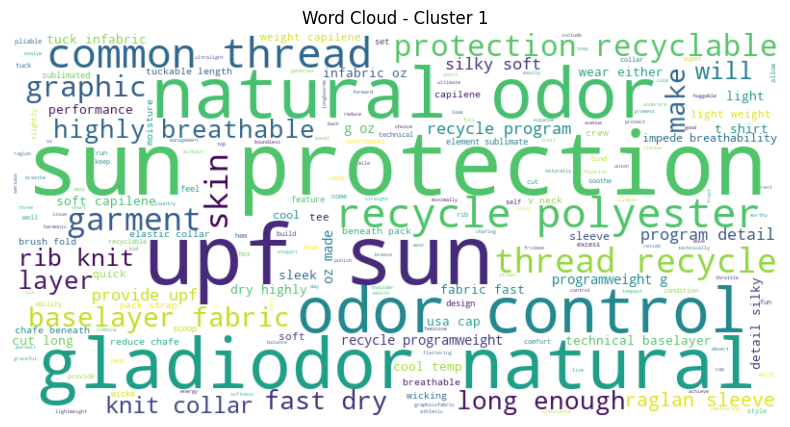

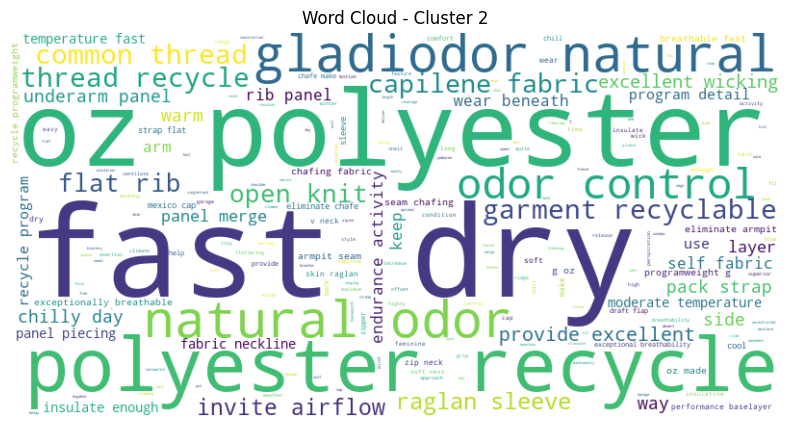

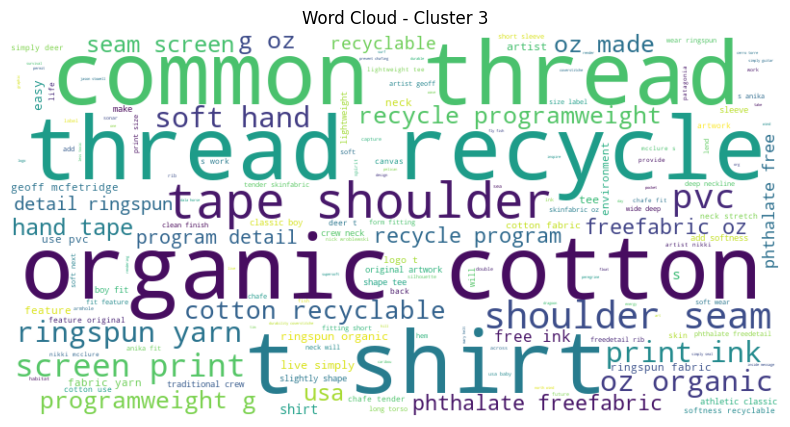

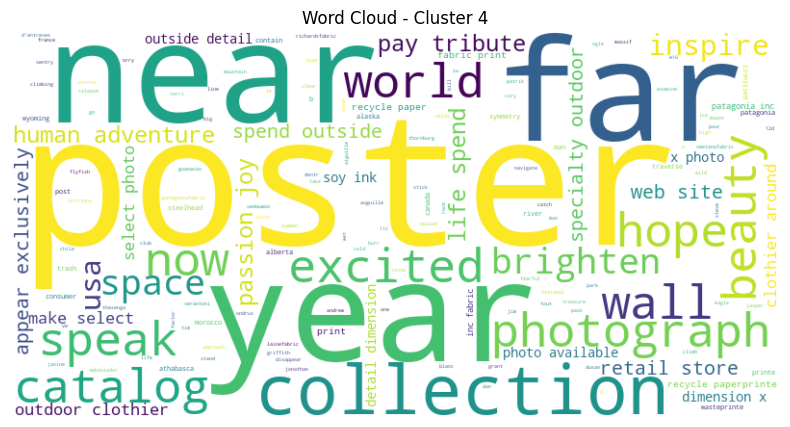

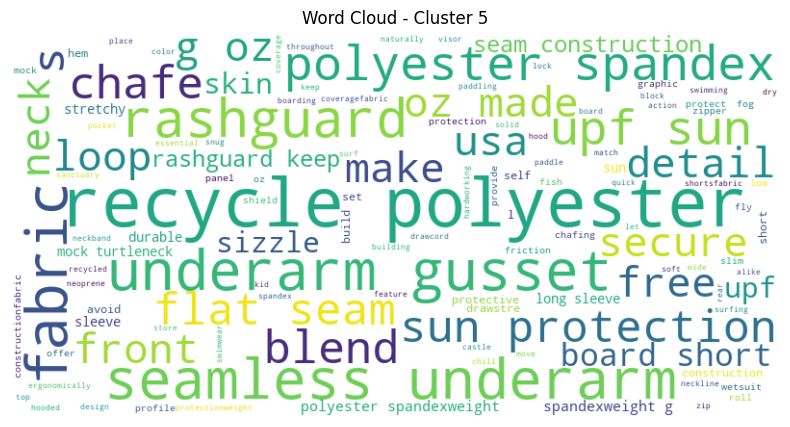

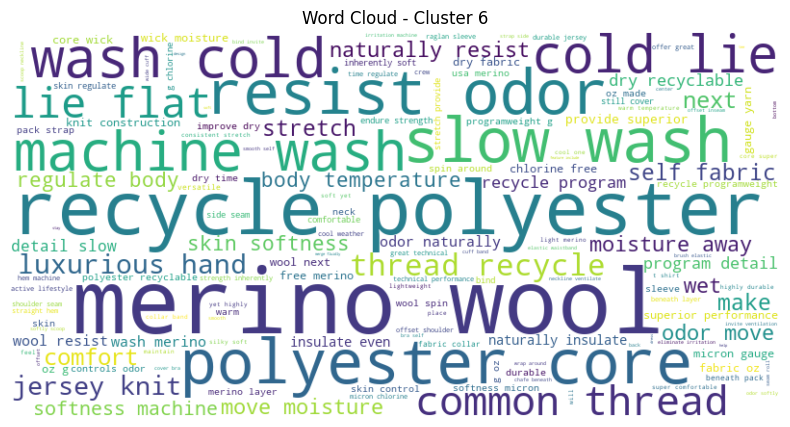

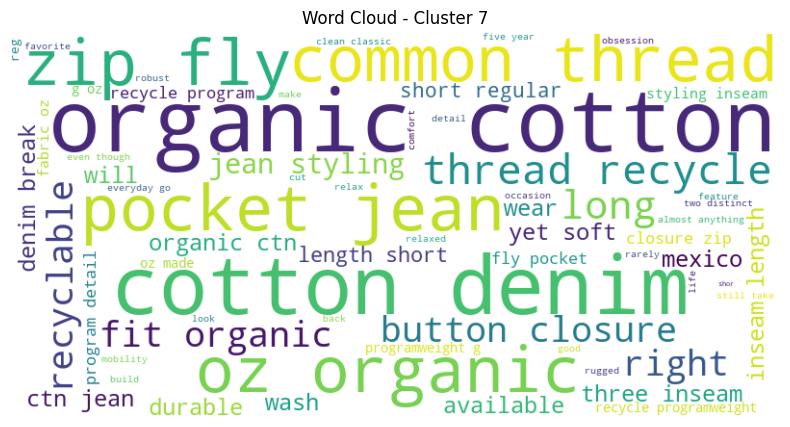

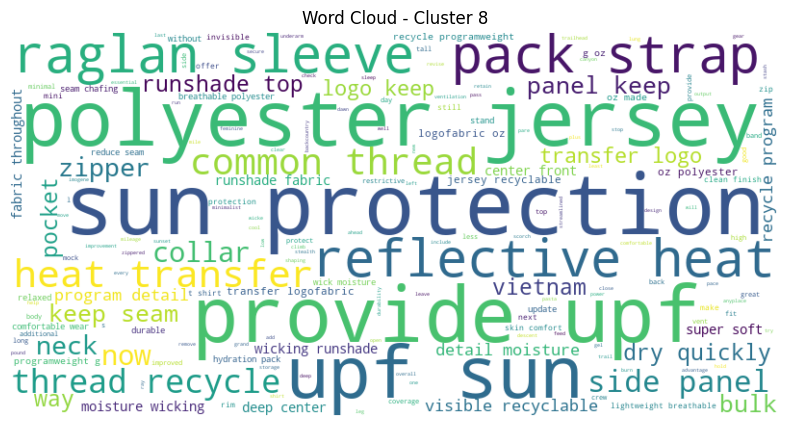

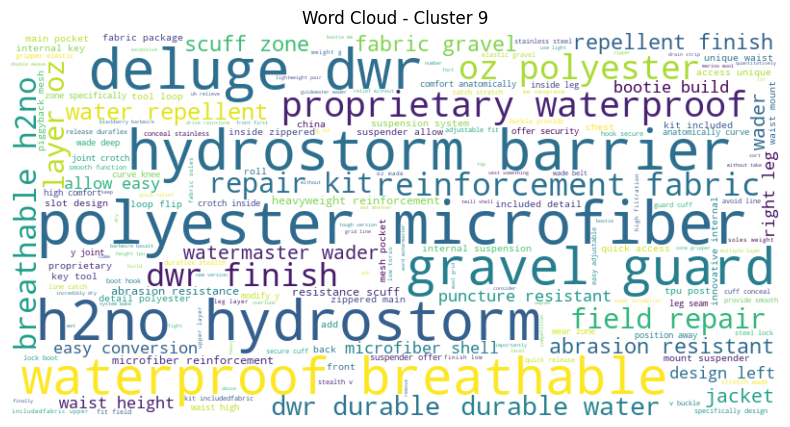

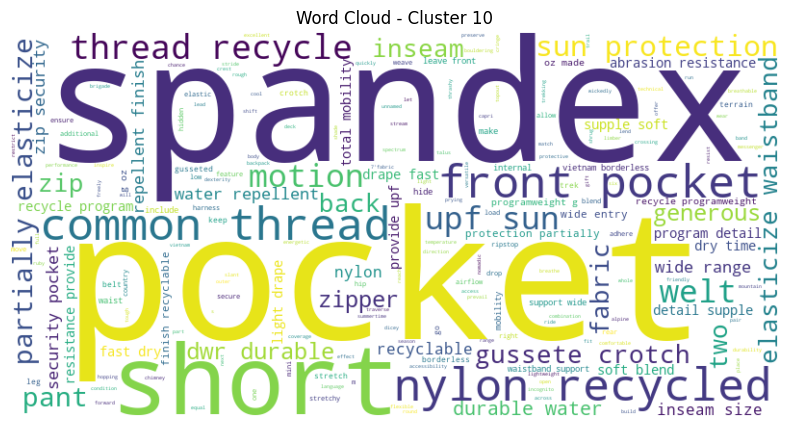

In [17]:
# display wordcloud by cluster
display_cluster_wordclouds(df, tfidf_matrix, clusters)

In [14]:
#similar items
item_id = 202
similar_items = find_similar_items(item_id, df)
if isinstance(similar_items, list):
    print(f"\nSimilar products to ID {item_id}:")
    for item in similar_items:
        print(f"- Product ID: {item}")
else:
    print(similar_items)


Similar products to ID 202:
- Product ID: 87
- Product ID: 88
- Product ID: 89
- Product ID: 90
- Product ID: 200


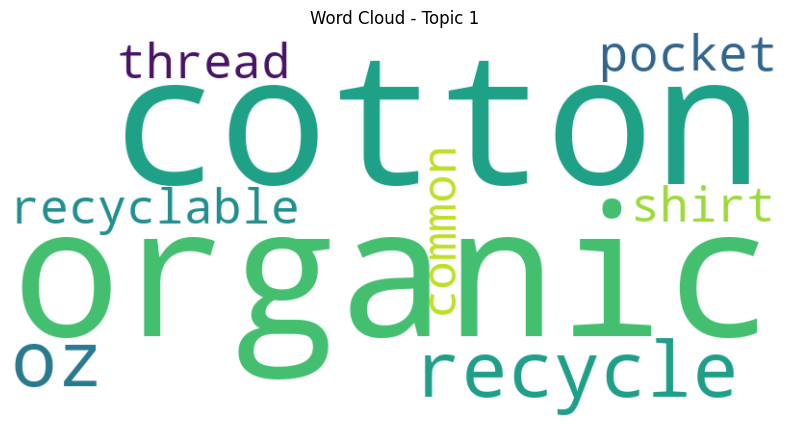

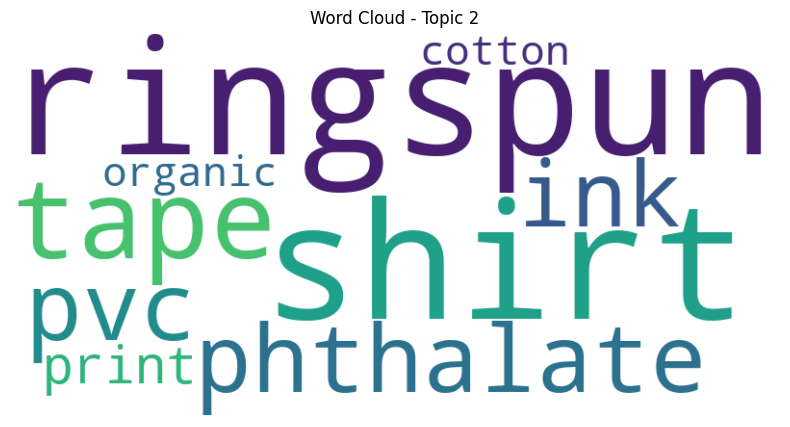

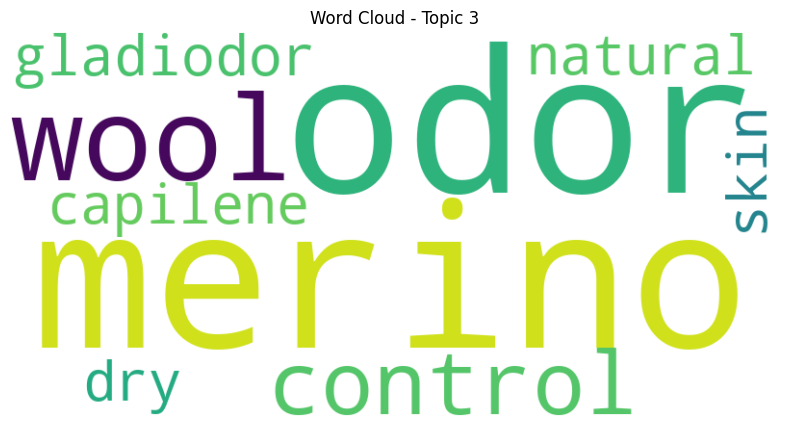

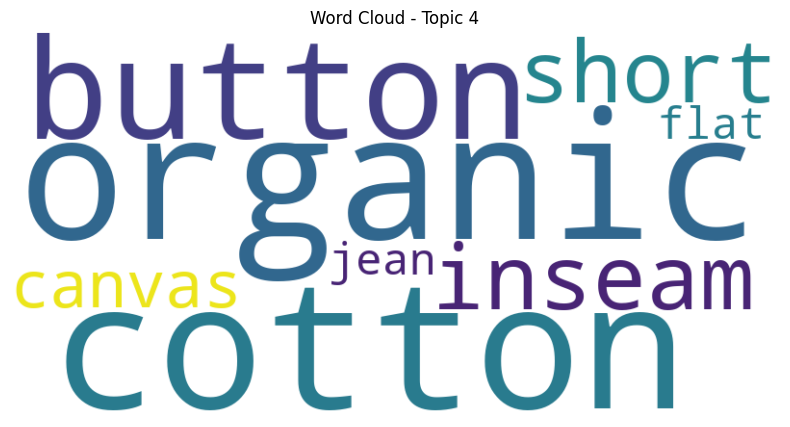

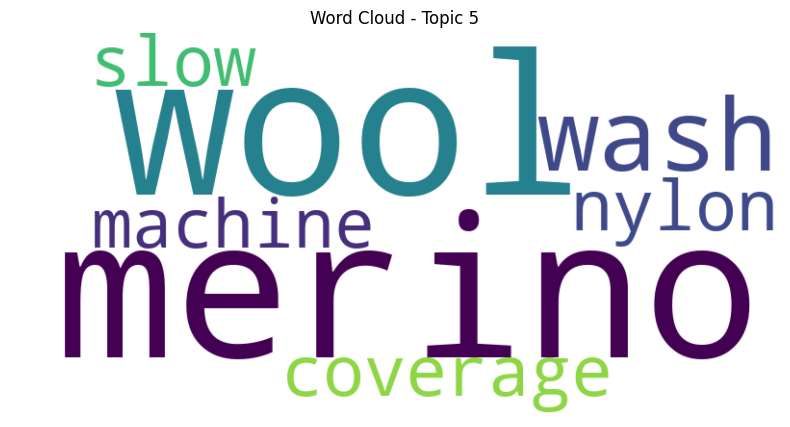

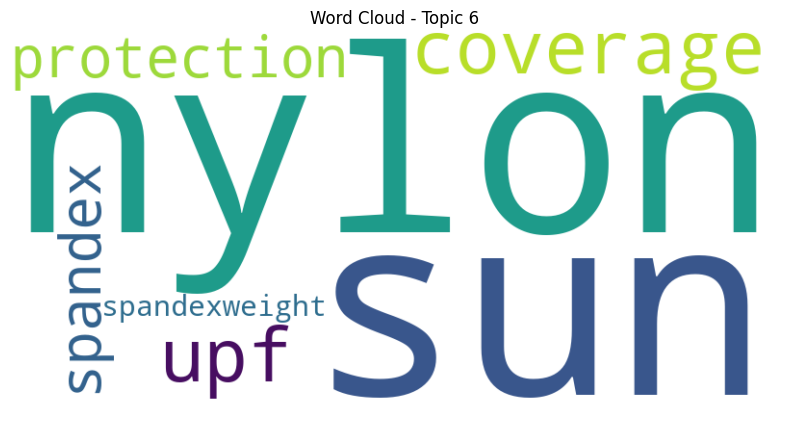

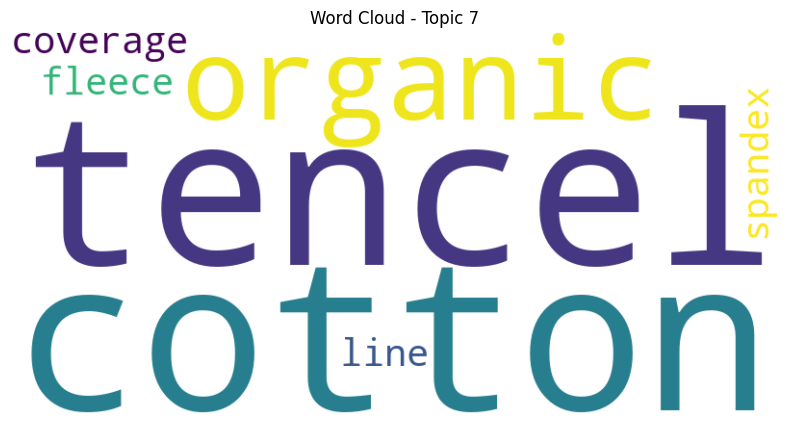

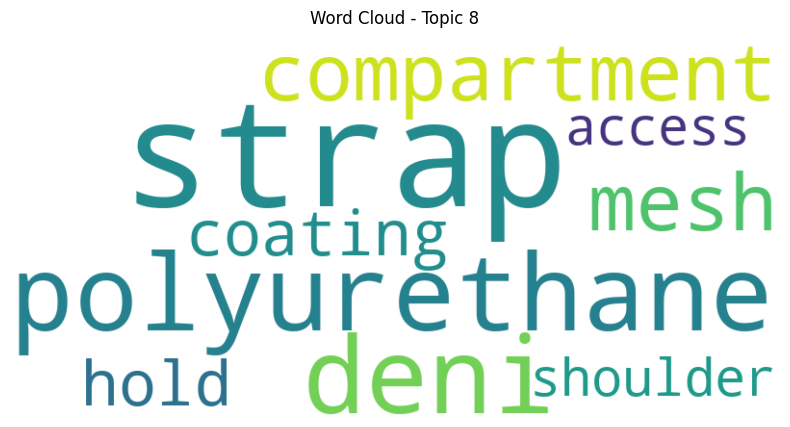

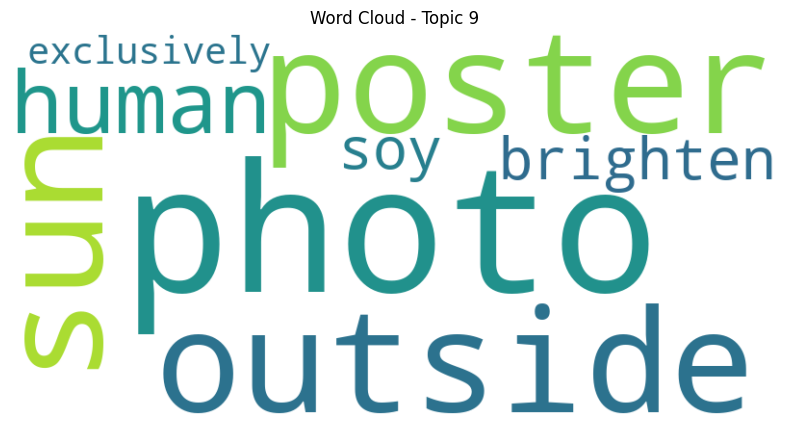

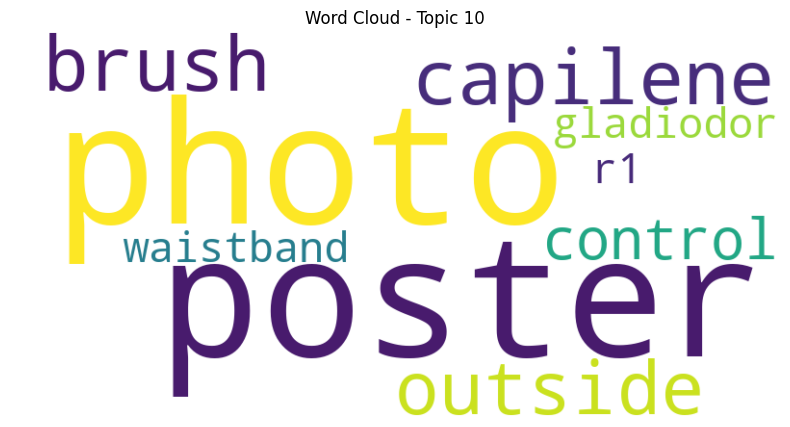

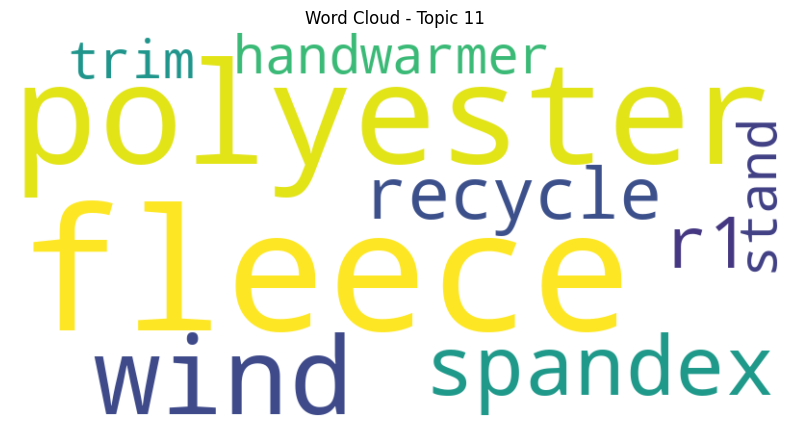

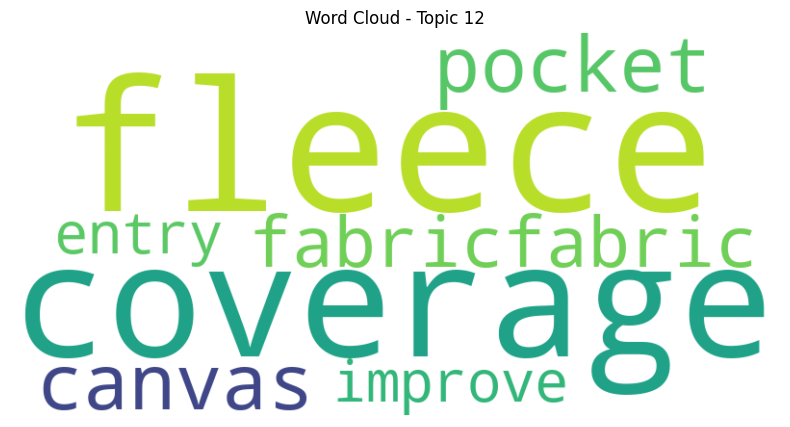

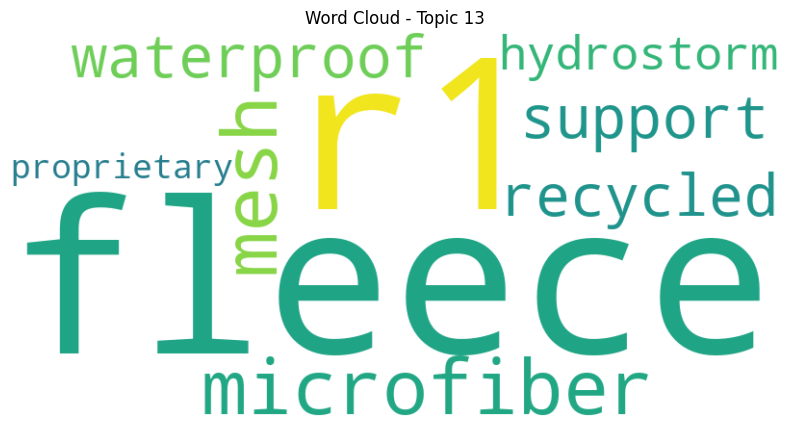

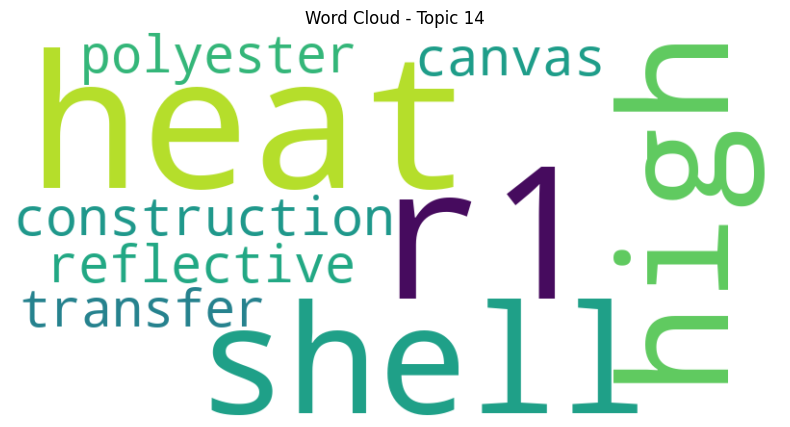

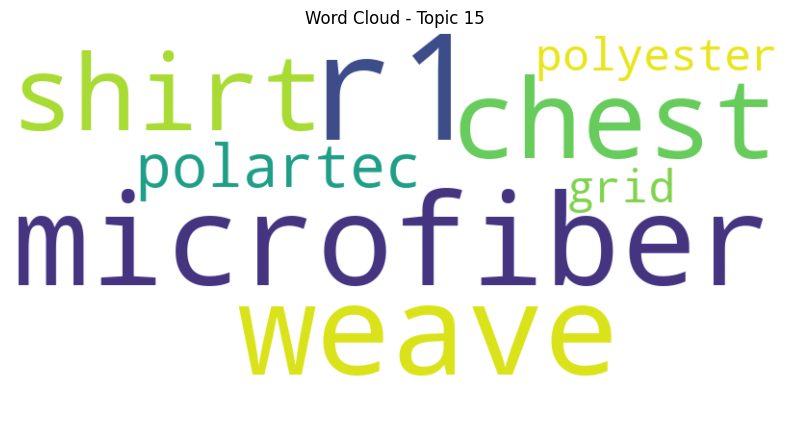

In [15]:
# topic wordclouds
display_topic_wordclouds(tfidf_matrix, svd, tfidf.get_feature_names_out(), n_topics)